# Training Deep Neural Networks

File name convention: For group 42 and memebers Richard Stallman and Linus <br> Torvalds it would be <br>
"06_Goup42_Stallman_Torvalds.pdf".

Submission via blackboard (UA).

Feel free to answer free text questions in text cells using markdown and <br>
possibly $\LaTeX{}$ if you want to.

**You don't have to understand every line of code here and it is not intended** <br> **for you to try to understand every line of code.**<br>
**Big blocks of code are usually meant to just be clicked through.**

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import torch
assert torch.__version__ >= "2.0"
from torch import nn
from torch.utils.data import DataLoader, Dataset

import keras

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
torch.manual_seed(42)
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

/Users/user/internship25/ML_exercies/.env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Vanishing/Exploding Gradients Problem

Just like with SGD for linear regression, the fundamental procedure in simple <br>
neural networks is to **update model weights and biases** by taking some form of <br>
**partial derivative of a loss function** with respect to our weights and biases <br>
and then **stepping our weights** in the direction of the negative partial <br>
derivative.

By **chain rule**, that means that we'll also need to have some kind of <br>
**partial derivative of our activation function** with respect to our weights and <br>
biases. If the **slope of an activation function** has a tendency to **explode** or <br>
**vanish**, then our gradient might also explode or vanish which means we end up <br>
taking **steps in our weights** that are **too large** or **too small**.

### TASK 1: Sigmoid, Relu, Leaky Relu

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

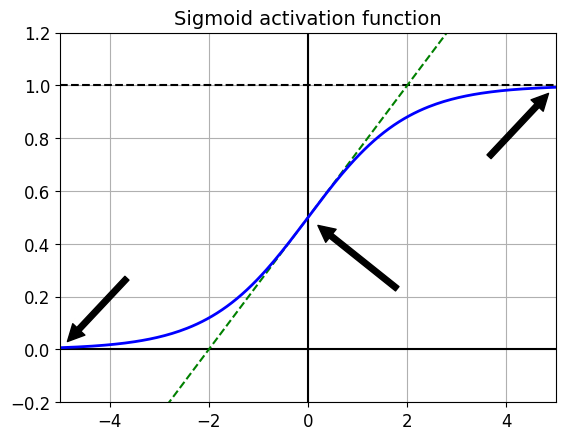

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

**Task 1 a)** Describe the sigmoid activation function in the three indicated <br>
regions in the above plot.

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your answer goes below

Task 1 a) answer

|x|> ~ 4 -> slope ~ 0 \
x ~ 0    -> slope ~ 1/4

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your answer goes above

### Leaky ReLU

**Task 1 b)** Write the [leaky relu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)#Leaky_ReLU) function as `def leaky_relu():`. <br>
It should take `z` as argument and also another optional argument `alpha` with <br> default value 0.01.<br>
The leaky relu function is defined to be `alpha*z` for z<0 and `z` for z>0.

(alterntively you can think about using `np.maximum` to make the distinction, <br> assuming alpha>0)

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

In [9]:
def leaky_relu(z, alpha=0.05):
    return np.where(z > 0, z, alpha * z)

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above

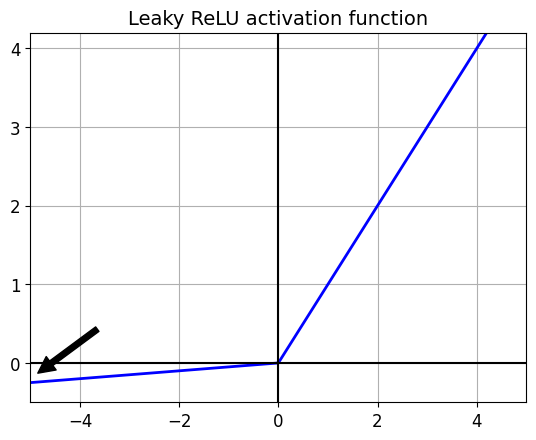

In [10]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

**Task 1c)** Describe the difference between relu and leaky relu?
Also explain why one might want to use leaky relu.

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your answer goes below

Task 1c) answer:

leaky relu is not zero at negative values -> non-zero gradient -> learning

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your answer goes above

##### Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [11]:
# load fashion MNIST + train_test split
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
class ClassificationDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.copy()).float()
        self.y = torch.from_numpy(y.copy()).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [13]:
train_data = ClassificationDataset(X_train, y_train)
valid_data = ClassificationDataset(X_valid, y_valid)
test_data = ClassificationDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=False)

In [14]:
torch.manual_seed(42)
np.random.seed(42)

model = torch.nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 10),
)

In [15]:
def train_and_validate(train_loader, val_loader, model, optimizer, criterion, num_epochs, metric):
    history = {
        'epoch': [],
        'train_loss': [],
        'train_metric': [],
        'val_loss': [],
        'val_metric': []
    }  # Initialize a dictionary to store epoch-wise results

    with torch.no_grad():
        proper_dtype = torch.int64
        X,y = next(iter(train_loader))
        try:
            loss = criterion(model(X), y.to(proper_dtype))
        except:
            try:
                proper_dtype = torch.float32
                loss = criterion(model(X), y.to(proper_dtype))
            except:
                print("No valid data-type could be found")

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0.0  # Initialize the epoch loss and metric values
        epoch_metric = 0.0

        # Training loop
        for X, y in train_loader:
            y = y.to(proper_dtype)
            optimizer.zero_grad()  # Clear existing gradients
            outputs = model(X)  # Make predictions
            loss = criterion(outputs, y)  # Compute the loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters

            epoch_loss += loss.item()
            epoch_metric += metric(outputs, y)

        # Average training loss and metric
        epoch_loss /= len(train_loader)
        epoch_metric /= len(train_loader)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            val_loss = 0.0
            val_metric = 0.0
            for X_val, y_val in val_loader:
                y_val = y_val.to(proper_dtype)
                outputs_val = model(X_val)  # Make predictions
                val_loss += criterion(outputs_val, y_val).item()  # Compute loss
                val_metric += metric(outputs_val, y_val)

            val_loss /= len(val_loader)
            val_metric /= len(val_loader)

        # Append epoch results to history
        history['epoch'].append(epoch)
        history['train_loss'].append(epoch_loss)
        history['train_metric'].append(epoch_metric)
        history['val_loss'].append(val_loss)
        history['val_metric'].append(val_metric)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, '
              f'Train Metric: {epoch_metric:.4f}, Val Loss: {val_loss:.4f}, '
              f'Val Metric: {val_metric:.4f}')

    return history, model

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

def accuracy_metric(pred, target):
    if len(pred.shape) == 1:
        accuracy = torch.sum(torch.eq(pred > 0.5, target)).item() / len(pred)
    else:
        pred = pred.argmax(dim=1)
        accuracy = torch.sum(pred == target).item() / len(pred)
    return accuracy

In [17]:
history, model = train_and_validate(train_loader, valid_loader, model,
                                    optimizer=optimizer, criterion=criterion,
                                    num_epochs=10, metric=accuracy_metric)

Epoch [1/10], Train Loss: 2.2718, Train Metric: 0.2384, Val Loss: 2.2315, Val Metric: 0.3792
Epoch [2/10], Train Loss: 2.1785, Train Metric: 0.4119, Val Loss: 2.1116, Val Metric: 0.4159
Epoch [3/10], Train Loss: 2.0091, Train Metric: 0.4537, Val Loss: 1.8796, Val Metric: 0.5182
Epoch [4/10], Train Loss: 1.7300, Train Metric: 0.5712, Val Loss: 1.5703, Val Metric: 0.6133
Epoch [5/10], Train Loss: 1.4556, Train Metric: 0.6115, Val Loss: 1.3360, Val Metric: 0.6250
Epoch [6/10], Train Loss: 1.2630, Train Metric: 0.6273, Val Loss: 1.1769, Val Metric: 0.6414
Epoch [7/10], Train Loss: 1.1285, Train Metric: 0.6417, Val Loss: 1.0645, Val Metric: 0.6549
Epoch [8/10], Train Loss: 1.0308, Train Metric: 0.6549, Val Loss: 0.9806, Val Metric: 0.6711
Epoch [9/10], Train Loss: 0.9576, Train Metric: 0.6684, Val Loss: 0.9183, Val Metric: 0.6808
Epoch [10/10], Train Loss: 0.9013, Train Metric: 0.6775, Val Loss: 0.8705, Val Metric: 0.6913


### TASK 2: ELU
**Task 2 a)** Describe the [ELU activation](https://paperswithcode.com/method/elu) function and compare to LeakyRelu. <br>
The definition is described in Chapter 11 or alternatively at the above link.

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your answer goes below

Task 2 a) answer:

x>0 \
ELU acts lile ReLU allowing unbounded positive activations and avoiding vanishing gradients 

x<0 \
Instead of outputting a flat zero (as ReLU) or a small negative slope (as Leaky ReLU), ELU smoothly (continous function) saturates toward a finite negative value

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your answer goes above

**Task 2 b)** Similar to `leaky_relu` above, write the function `def elu():` as <br> a function of z with optional argument `alpha=1` (meaning that the default <br> value is 1).

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

In [20]:
from numpy import exp

In [21]:
def elu(z, alpha = 1):
    return np.where(z > 0, z, alpha * (exp(z) - 1))

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above

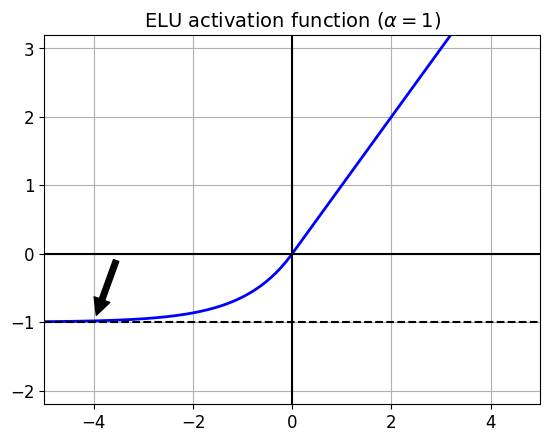

In [22]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.annotate('', xytext=(-3.5, 0), xy=(-4, -1), arrowprops=props, fontsize=14, ha="center")
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [23]:
torch.manual_seed(42)
np.random.seed(42)

To use the elu activation function in TensorFlow you need to specify the <Br> activation function when building each layer (Check on the [Pytorch Website](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)
<br>
for some examples): <br>
`nn.ELU()`

**Task 2 c)** Using the same layer dimensions from the previous model <br> (LeakyRelu), train with ELU activation instead.

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

In [28]:
model = torch.nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 300),
    nn.ELU(),
    nn.Linear(300, 100),
    nn.ELU(),
    nn.Linear(100, 10),
)

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

def accuracy_metric(pred, target):
    if len(pred.shape) == 1:
        accuracy = torch.sum(torch.eq(pred > 0.5, target)).item() / len(pred)
    else:
        pred = pred.argmax(dim=1)
        accuracy = torch.sum(pred == target).item() / len(pred)
    return accuracy

In [30]:
history, model = train_and_validate(train_loader, valid_loader, model,
                                    optimizer=optimizer, criterion=criterion,
                                    num_epochs=10, metric=accuracy_metric)

Epoch [1/10], Train Loss: 2.1774, Train Metric: 0.3209, Val Loss: 2.0453, Val Metric: 0.5156
Epoch [2/10], Train Loss: 1.8824, Train Metric: 0.5536, Val Loss: 1.6970, Val Metric: 0.5724
Epoch [3/10], Train Loss: 1.5410, Train Metric: 0.5815, Val Loss: 1.3848, Val Metric: 0.6046
Epoch [4/10], Train Loss: 1.2869, Train Metric: 0.6209, Val Loss: 1.1807, Val Metric: 0.6327
Epoch [5/10], Train Loss: 1.1208, Train Metric: 0.6412, Val Loss: 1.0473, Val Metric: 0.6600
Epoch [6/10], Train Loss: 1.0096, Train Metric: 0.6611, Val Loss: 0.9564, Val Metric: 0.6820
Epoch [7/10], Train Loss: 0.9315, Train Metric: 0.6766, Val Loss: 0.8911, Val Metric: 0.6960
Epoch [8/10], Train Loss: 0.8742, Train Metric: 0.6909, Val Loss: 0.8417, Val Metric: 0.7043
Epoch [9/10], Train Loss: 0.8303, Train Metric: 0.7020, Val Loss: 0.8033, Val Metric: 0.7148
Epoch [10/10], Train Loss: 0.7953, Train Metric: 0.7144, Val Loss: 0.7720, Val Metric: 0.7225


## Task 3: Batch Normalization
**Task 3 a)** Build a NN with two hidden layers with 300 and 100 nodes. Use <br>
RELU as activation function. Add [Batch Normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) layers before each <br>
dense layer (check the definition in Chapter 11)   

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

In [38]:
model = nn.Sequential(
    nn.Flatten(),
    # ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
    nn.BatchNorm1d(28*28),
    nn.Linear(28*28, 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Linear(300, 100),
    nn.ReLU(),
    # ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
    nn.Linear(100, 10),
)

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above

In [39]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

def accuracy_metric(pred, target):
    if len(pred.shape) == 1:
        accuracy = torch.sum(torch.eq(pred > 0.5, target)).item() / len(pred)
    else:
        pred = pred.argmax(dim=1)
        accuracy = torch.sum(pred == target).item() / len(pred)
    return accuracy

In [40]:
history, model = train_and_validate(train_loader, valid_loader, model,
                                    optimizer=optimizer, criterion=criterion,
                                    num_epochs=25, metric=accuracy_metric)

Epoch [1/25], Train Loss: 1.5457, Train Metric: 0.5801, Val Loss: 1.0615, Val Metric: 0.7186
Epoch [2/25], Train Loss: 0.9325, Train Metric: 0.7303, Val Loss: 0.7685, Val Metric: 0.7629
Epoch [3/25], Train Loss: 0.7280, Train Metric: 0.7669, Val Loss: 0.6323, Val Metric: 0.7872
Epoch [4/25], Train Loss: 0.6267, Train Metric: 0.7909, Val Loss: 0.5653, Val Metric: 0.8143
Epoch [5/25], Train Loss: 0.5660, Train Metric: 0.8092, Val Loss: 0.5178, Val Metric: 0.8269
Epoch [6/25], Train Loss: 0.5287, Train Metric: 0.8176, Val Loss: 0.4821, Val Metric: 0.8370
Epoch [7/25], Train Loss: 0.4975, Train Metric: 0.8270, Val Loss: 0.4589, Val Metric: 0.8455
Epoch [8/25], Train Loss: 0.4756, Train Metric: 0.8348, Val Loss: 0.4431, Val Metric: 0.8495
Epoch [9/25], Train Loss: 0.4609, Train Metric: 0.8383, Val Loss: 0.4241, Val Metric: 0.8538
Epoch [10/25], Train Loss: 0.4448, Train Metric: 0.8435, Val Loss: 0.4151, Val Metric: 0.8600
Epoch [11/25], Train Loss: 0.4333, Train Metric: 0.8476, Val Loss: 0.

In [41]:
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=784, out_features=300, bias=True)
  (3): ReLU()
  (4): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Linear(in_features=300, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=10, bias=True)
)


**Task 3 b)** Explain what batch normalization does and discuss the results of above training.

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your answer goes below

Task 3b) answer:

Compute batch mean/variance \
Normalize \
Apply affine transform \
Maintain running averages for inference

Zero-centers and unit-scales each feature across the mini-batch, then learns a rescaling (γ) and shift (β) 


Results show  convergence and stable loss trajectories

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your answer goes above

## Task 4: Reusing a Pytorch model

Let's split the fashion MNIST training set in two: <br>
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).<br>
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without <br>
restricting the number of images.

**We will train a model on set A (classification task with 8 classes), and try to** <br>
**reuse it to tackle set B (binary classification).** We hope to transfer a little <br>
bit of knowledge from task A to task B, since classes in set A (sneakers, <br>
ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B <br>
(sandals and shirts). However, **since we are using `Dense` layers, only patterns** <br>
**that occur at the same location can be reused** (in contrast, **convolutional <br> layers will transfer much better**, since learned patterns can be detected <br>
anywhere on the image, as we will see in the CNN chapter).

In [42]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [43]:
class ClassificationDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.copy()).float()
        self.y = torch.from_numpy(y.copy()).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [44]:
train_data = ClassificationDataset(X_train_A, y_train_A)
valid_data = ClassificationDataset(X_valid_A, y_valid_A)
test_data = ClassificationDataset(X_test_A, y_test_A)

train_loader_A = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader_A = DataLoader(test_data, batch_size=64, shuffle=False)
valid_loader_A = DataLoader(valid_data, batch_size=64, shuffle=False)

In [45]:
train_data = ClassificationDataset(X_train_B, y_train_B)
valid_data = ClassificationDataset(X_valid_B, y_valid_B)
test_data = ClassificationDataset(X_test_B, y_test_B)

train_loader_B = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader_B = DataLoader(test_data, batch_size=64, shuffle=False)
valid_loader_B = DataLoader(valid_data, batch_size=64, shuffle=False)

In [46]:
torch.manual_seed(42)
np.random.seed(42)

In [47]:
model_A = nn.Sequential()
model_A.append(nn.Flatten())
n_last = 28*28
for n_hidden in (300, 100, 50, 50, 50):
    model_A.append(nn.Linear(n_last, n_hidden))
    model_A.append(nn.SELU())
    n_last = n_hidden
model_A.append(nn.Linear(n_last, 8))

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=300, bias=True)
  (2): SELU()
  (3): Linear(in_features=300, out_features=100, bias=True)
  (4): SELU()
  (5): Linear(in_features=100, out_features=50, bias=True)
  (6): SELU()
  (7): Linear(in_features=50, out_features=50, bias=True)
  (8): SELU()
  (9): Linear(in_features=50, out_features=50, bias=True)
  (10): SELU()
  (11): Linear(in_features=50, out_features=8, bias=True)
)

In [48]:
criterion_A = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_A.parameters(), lr=0.001)

def accuracy_metric(pred, target):
    if len(pred.shape) == 1:
        accuracy = torch.sum(torch.eq(pred > 0.5, target)).item() / len(pred)
    else:
        pred = pred.argmax(dim=1)
        accuracy = torch.sum(pred == target).item() / len(pred)
    return accuracy

In [49]:
history_A, model_A = train_and_validate(train_loader_A, valid_loader_A, model_A,
                                        optimizer=optimizer, criterion=criterion_A,
                                        num_epochs=30, metric=accuracy_metric)

Epoch [1/30], Train Loss: 1.9313, Train Metric: 0.4385, Val Loss: 1.7502, Val Metric: 0.5501
Epoch [2/30], Train Loss: 1.5114, Train Metric: 0.6223, Val Loss: 1.2759, Val Metric: 0.6607
Epoch [3/30], Train Loss: 1.1340, Train Metric: 0.6585, Val Loss: 1.0003, Val Metric: 0.6815
Epoch [4/30], Train Loss: 0.9253, Train Metric: 0.6988, Val Loss: 0.8443, Val Metric: 0.7169
Epoch [5/30], Train Loss: 0.7979, Train Metric: 0.7232, Val Loss: 0.7438, Val Metric: 0.7372
Epoch [6/30], Train Loss: 0.7080, Train Metric: 0.7589, Val Loss: 0.6662, Val Metric: 0.7966
Epoch [7/30], Train Loss: 0.6326, Train Metric: 0.8105, Val Loss: 0.5969, Val Metric: 0.8352
Epoch [8/30], Train Loss: 0.5643, Train Metric: 0.8379, Val Loss: 0.5326, Val Metric: 0.8477
Epoch [9/30], Train Loss: 0.5059, Train Metric: 0.8471, Val Loss: 0.4812, Val Metric: 0.8529
Epoch [10/30], Train Loss: 0.4611, Train Metric: 0.8544, Val Loss: 0.4426, Val Metric: 0.8606
Epoch [11/30], Train Loss: 0.4292, Train Metric: 0.8600, Val Loss: 0.

In [50]:
model_B = nn.Sequential()
model_B.append(nn.Flatten())
n_last = 28*28
for n_hidden in (300, 100, 50, 50, 50):
    model_B.append(nn.Linear(n_last, n_hidden))
    model_B.append(nn.SELU())
    n_last = n_hidden
model_B.append(nn.Linear(n_last, 1))
model_B.append(nn.Sigmoid())
model_B.append(nn.Flatten(start_dim=0))

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=300, bias=True)
  (2): SELU()
  (3): Linear(in_features=300, out_features=100, bias=True)
  (4): SELU()
  (5): Linear(in_features=100, out_features=50, bias=True)
  (6): SELU()
  (7): Linear(in_features=50, out_features=50, bias=True)
  (8): SELU()
  (9): Linear(in_features=50, out_features=50, bias=True)
  (10): SELU()
  (11): Linear(in_features=50, out_features=1, bias=True)
  (12): Sigmoid()
  (13): Flatten(start_dim=0, end_dim=-1)
)

In [51]:
criterion_B = nn.BCELoss()
optimizer = torch.optim.SGD(model_B.parameters(), lr=0.001)

def accuracy_metric(pred, target):
    if len(pred.shape) == 1:
        accuracy = torch.sum(torch.eq(pred > 0.5, target)).item() / len(pred)
    else:
        pred = pred.argmax(dim=1)
        accuracy = torch.sum(pred == target).item() / len(pred)
    return accuracy

In [52]:
history_B, model_B = train_and_validate(train_loader_B, valid_loader_B, model_B,
                                        optimizer=optimizer, criterion=criterion_B,
                                        num_epochs=30, metric=accuracy_metric)

Epoch [1/30], Train Loss: 0.6977, Train Metric: 0.4102, Val Loss: 0.6892, Val Metric: 0.5014
Epoch [2/30], Train Loss: 0.6879, Train Metric: 0.5195, Val Loss: 0.6883, Val Metric: 0.5014
Epoch [3/30], Train Loss: 0.6886, Train Metric: 0.4922, Val Loss: 0.6875, Val Metric: 0.5014
Epoch [4/30], Train Loss: 0.6932, Train Metric: 0.4375, Val Loss: 0.6867, Val Metric: 0.5014
Epoch [5/30], Train Loss: 0.6831, Train Metric: 0.5469, Val Loss: 0.6858, Val Metric: 0.5014
Epoch [6/30], Train Loss: 0.6886, Train Metric: 0.4648, Val Loss: 0.6850, Val Metric: 0.5014
Epoch [7/30], Train Loss: 0.6871, Train Metric: 0.4688, Val Loss: 0.6842, Val Metric: 0.5014
Epoch [8/30], Train Loss: 0.6841, Train Metric: 0.4961, Val Loss: 0.6834, Val Metric: 0.5014
Epoch [9/30], Train Loss: 0.6848, Train Metric: 0.4688, Val Loss: 0.6826, Val Metric: 0.5014
Epoch [10/30], Train Loss: 0.6831, Train Metric: 0.4961, Val Loss: 0.6818, Val Metric: 0.5014
Epoch [11/30], Train Loss: 0.6829, Train Metric: 0.4688, Val Loss: 0.

In [53]:
model_B_on_A = nn.Sequential()
for module in list(model_A.modules())[1:]:
    model_B_on_A.append(module)
model_B_on_A.append(nn.Linear(8, 1))
model_B_on_A.append(nn.Sigmoid())
model_B_on_A.append(nn.Flatten(start_dim=0))

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=300, bias=True)
  (2): SELU()
  (3): Linear(in_features=300, out_features=100, bias=True)
  (4): SELU()
  (5): Linear(in_features=100, out_features=50, bias=True)
  (6): SELU()
  (7): Linear(in_features=50, out_features=50, bias=True)
  (8): SELU()
  (9): Linear(in_features=50, out_features=50, bias=True)
  (10): SELU()
  (11): Linear(in_features=50, out_features=8, bias=True)
  (12): Linear(in_features=8, out_features=1, bias=True)
  (13): Sigmoid()
  (14): Flatten(start_dim=0, end_dim=-1)
)

Note that `model_B_on_A` and `model_A` actually share layers now, so **when we** <br>
**train one, it will update both models**. If we want **to avoid that**, we need to <br>
**build `model_B_on_A` on top of a clone of `model_A`**:

In [54]:
import copy

In [55]:
model_A_clone = copy.deepcopy(model_A)
model_A_clone.load_state_dict(model_A.state_dict())

<All keys matched successfully>

In [56]:
for param in model_B_on_A.parameters():
    param.requires_grad = False

In [57]:
optimizer = torch.optim.SGD(model_B_on_A.parameters(), lr=0.001)

In [58]:
for param in model_B_on_A.parameters():
    param.requires_grad = True

history_B_on_A, model_B_on_A = train_and_validate(train_loader_B, valid_loader_B, model_B_on_A,
                                                  optimizer=optimizer, criterion=criterion_B,
                                                  num_epochs=30, metric=accuracy_metric)

Epoch [1/30], Train Loss: 1.4012, Train Metric: 0.0898, Val Loss: 1.1491, Val Metric: 0.1825
Epoch [2/30], Train Loss: 1.1006, Train Metric: 0.1719, Val Loss: 0.9849, Val Metric: 0.2553
Epoch [3/30], Train Loss: 0.9082, Train Metric: 0.3594, Val Loss: 0.8499, Val Metric: 0.3811
Epoch [4/30], Train Loss: 0.7986, Train Metric: 0.4492, Val Loss: 0.7366, Val Metric: 0.5260
Epoch [5/30], Train Loss: 0.7034, Train Metric: 0.6016, Val Loss: 0.6396, Val Metric: 0.6552
Epoch [6/30], Train Loss: 0.5924, Train Metric: 0.6875, Val Loss: 0.5651, Val Metric: 0.7332
Epoch [7/30], Train Loss: 0.5261, Train Metric: 0.8164, Val Loss: 0.5046, Val Metric: 0.7981
Epoch [8/30], Train Loss: 0.4772, Train Metric: 0.8320, Val Loss: 0.4537, Val Metric: 0.8542
Epoch [9/30], Train Loss: 0.3929, Train Metric: 0.8984, Val Loss: 0.4138, Val Metric: 0.8873
Epoch [10/30], Train Loss: 0.3639, Train Metric: 0.9453, Val Loss: 0.3773, Val Metric: 0.9234
Epoch [11/30], Train Loss: 0.3231, Train Metric: 0.9727, Val Loss: 0.

Task 4:
a) Evaluate the loss and accuracy of the two models `model_B` and <br> `model_B_on_A` on the sandals/shirts dataset.

In [59]:
def test_model(model, data_loader, criterion, metric=None):
    model.eval()  # Set the model to evaluation mode

    total_loss = 0.0  # Initialize the total loss and metric values
    total_metric = 0.0

    with torch.no_grad():
        proper_dtype = torch.int64
        X,y = next(iter(train_loader))
        try:
            loss = criterion(model(X), y.to(proper_dtype))
        except:
            try:
                proper_dtype = torch.float32
                loss = criterion(model(X), y.to(proper_dtype))
            except:
                print("No valid data-type could be found")


    with torch.no_grad():  # Disable gradient tracking
        for batch in data_loader:
            X, y = batch
            y = y.to(proper_dtype)
            # Pass the data to the model and make predictions
            outputs = model(X)

            # Compute the loss
            loss = criterion(outputs, y)

            # Add the loss and metric for the batch to the total values
            total_loss += loss.item()

            # THESE LINES HAVE BEEN UPDATED TO ACCOUNT FOR DEFAULT ARGUMENTS
            if metric is not None:
                total_metric += metric(outputs, y)
            else:
                total_metric += 0.0

    # Average loss and metric for the entire dataset
    avg_loss = total_loss / len(data_loader)
    avg_metric = total_metric / len(data_loader)

    print(f'Test Loss: {avg_loss:.4f}, Test Metric: {avg_metric:.4f}')

    return avg_loss, avg_metric

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

In [60]:
test_model(model_B, test_loader_B, criterion_B)

No valid data-type could be found
Test Loss: 0.6670, Test Metric: 0.0000


(0.6669772230088711, 0.0)

In [61]:
test_model(model_B_on_A, test_loader_B, criterion_B)

No valid data-type could be found
Test Loss: 0.1255, Test Metric: 0.0000


(0.12545937160030007, 0.0)

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above

b) In your own words, explain above "transfer learning". Did it help?

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your answer goes below

Task:

From scratch (Model B): Test Loss ≈0.667, chance-level accuracy ≈0.50 \
Transfer (Model B_on_A): Test Loss ≈0.125, accuracy ≈0.98 \
Conclusion: Reusing pretrained weights gives you a huge head start when you have very little data for your new task.

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your answer goes above

## Task 5: Learning Rate Scheduling

Just like when we learned about SGD for linear regression, **decreasing the** <br>
**learning rate over time can improve convergence**. One way to do this is to write <br>
a schedule to decay the learning rate as a function of epoch number.

Let's add a an exponential decay of the learning rate:

We will use the following learning rate schedule (exponential):   
$ lr = lr_0 \cdot 0.1 ^ {epoch / 20}$

In [62]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

**Note: If you want to use learning rate decay, it is probably better to use a** <br>
**Pytorch built-in function like [ExponentialLR](hhttps://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR) and not program it yourself.**

In order to make our training loop more flexible, we'll add **default values** of <br>
`None` for the **metric** and **scheduler**. Depending on the task, we might not <br>
always need or want to use a metric or scheduler but this will be our new <br>
train and validation loop. We've also added **learning rate tracking** to our <br>
model history output.

In [64]:
def train_and_validate(train_loader, val_loader, model, optimizer, criterion, num_epochs, metric=None, scheduler=None):
    history = {
        'epoch': [],
        'train_loss': [],
        'train_metric': [],
        'val_loss': [],
        'val_metric': [],
        'learning_rate': []
    }  # Initialize a dictionary to store epoch-wise results

    with torch.no_grad():
        proper_dtype = torch.int64
        X,y = next(iter(train_loader))
        try:
            loss = criterion(model(X), y.to(proper_dtype))
        except:
            try:
                proper_dtype = torch.float32
                loss = criterion(model(X), y.to(proper_dtype))
            except:
                print("No valid data-type could be found")

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0.0  # Initialize the epoch loss and metric values
        epoch_metric = 0.0

        # Training loop
        for X, y in train_loader:
            y = y.to(proper_dtype)
            optimizer.zero_grad()  # Clear existing gradients
            outputs = model(X)  # Make predictions
            loss = criterion(outputs, y)  # Compute the loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters

            epoch_loss += loss.item()

            # THESE LINES HAVE BEEN UPDATED TO ACCOUNT FOR DEFAULT ARGUMENTS
            if metric is not None:
                epoch_metric += metric(outputs, y)
            else:
                epoch_metric += 0.0

        # Average training loss and metric
        epoch_loss /= len(train_loader)
        epoch_metric /= len(train_loader)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            val_loss = 0.0
            val_metric = 0.0
            for X_val, y_val in val_loader:
                y_val = y_val.to(proper_dtype)
                outputs_val = model(X_val)  # Make predictions
                val_loss += criterion(outputs_val, y_val).item()  # Compute loss
                if metric is not None:
                    val_metric += metric(outputs_val, y_val)
                else:
                    val_metric += 0.0

            val_loss /= len(val_loader)
            val_metric /= len(val_loader)

        # Append epoch results to history
        history['epoch'].append(epoch)
        history['train_loss'].append(epoch_loss)
        history['train_metric'].append(epoch_metric)
        history['val_loss'].append(val_loss)
        history['val_metric'].append(val_metric)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, '
              f'Train Metric: {epoch_metric:.4f}, Val Loss: {val_loss:.4f}, '
              f'Val Metric: {val_metric:.4f}')

        # THESE LINES ARE NEW AND ACCOUNT FOR SCHEDULERS
        if scheduler is not None:
            scheduler.step()

    return history, model

**Task 5:**
- Build a NN with: two hidden layers with 300 and 100 nodes, add <br>
Batch Normalization layers before the linear layers,
- Train the model with `nn.CrossEntropyLoss()` as `criterion`, <br> `scheduler` and `optimizer` provided above and `accuracy` as the `metric`, <br>
- Fit the model to `train_loader` for 25 epochs. Use `valid_loader` for the <br>
validation data.

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

In [88]:
model = nn.Sequential(
    nn.Flatten(),
    nn.BatchNorm1d(28*28),
    nn.Linear(28*28, 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 10),
)
criterion = nn.CrossEntropyLoss()
metric = accuracy_metric
optimizer = torch.optim.NAdam(model.parameters())
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, exponential_decay_fn)
num_epochs = 25

In [89]:
history, model = train_and_validate(train_loader, valid_loader, model, optimizer, criterion, num_epochs, metric, scheduler)

Epoch [1/25], Train Loss: 0.8714, Train Metric: 0.7440, Val Loss: 0.5759, Val Metric: 0.8341


/Users/user/internship25/ML_exercies/.env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [2/25], Train Loss: 0.5421, Train Metric: 0.8306, Val Loss: 0.4675, Val Metric: 0.8580
Epoch [3/25], Train Loss: 0.4614, Train Metric: 0.8514, Val Loss: 0.4150, Val Metric: 0.8685
Epoch [4/25], Train Loss: 0.4164, Train Metric: 0.8630, Val Loss: 0.3922, Val Metric: 0.8762
Epoch [5/25], Train Loss: 0.3869, Train Metric: 0.8700, Val Loss: 0.3736, Val Metric: 0.8788
Epoch [6/25], Train Loss: 0.3637, Train Metric: 0.8767, Val Loss: 0.3578, Val Metric: 0.8801
Epoch [7/25], Train Loss: 0.3447, Train Metric: 0.8829, Val Loss: 0.3479, Val Metric: 0.8833
Epoch [8/25], Train Loss: 0.3284, Train Metric: 0.8868, Val Loss: 0.3523, Val Metric: 0.8886
Epoch [9/25], Train Loss: 0.3168, Train Metric: 0.8900, Val Loss: 0.3261, Val Metric: 0.8912
Epoch [10/25], Train Loss: 0.3042, Train Metric: 0.8948, Val Loss: 0.3299, Val Metric: 0.8938
Epoch [11/25], Train Loss: 0.2939, Train Metric: 0.8971, Val Loss: 0.3277, Val Metric: 0.8936
Epoch [12/25], Train Loss: 0.2823, Train Metric: 0.9022, Val Loss: 0

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above

Let's check out our model performance with a test loop.

In [90]:
def test_model(model, data_loader, criterion, metric=None):
    model.eval()  # Set the model to evaluation mode

    total_loss = 0.0  # Initialize the total loss and metric values
    total_metric = 0.0

    with torch.no_grad():
        proper_dtype = torch.int64
        X,y = next(iter(train_loader))
        try:
            loss = criterion(model(X), y.to(proper_dtype))
        except:
            try:
                proper_dtype = torch.float32
                loss = criterion(model(X), y.to(proper_dtype))
            except:
                print("No valid data-type could be found")


    with torch.no_grad():  # Disable gradient tracking
        for batch in data_loader:
            X, y = batch
            y = y.to(proper_dtype)
            # Pass the data to the model and make predictions
            outputs = model(X)

            # Compute the loss
            loss = criterion(outputs, y)

            # Add the loss and metric for the batch to the total values
            total_loss += loss.item()

            # THESE LINES HAVE BEEN UPDATED TO ACCOUNT FOR DEFAULT ARGUMENTS
            if metric is not None:
                total_metric += metric(outputs, y)
            else:
                total_metric += 0.0

    # Average loss and metric for the entire dataset
    avg_loss = total_loss / len(data_loader)
    avg_metric = total_metric / len(data_loader)

    print(f'Test Loss: {avg_loss:.4f}, Test Metric: {avg_metric:.4f}')

    return avg_loss, avg_metric

In [91]:
# note that the model is overfitting a lot. Might want to use dropout
# also a CNN will perform much better as we will see next Hands-On
print("train loss:", test_model(model, train_loader, nn.CrossEntropyLoss())[0])
print()
print("test loss:", test_model(model, test_loader, nn.CrossEntropyLoss())[0])

Test Loss: 0.1785, Test Metric: 0.0000
train loss: 0.1785416752793068

Test Loss: 0.3432, Test Metric: 0.0000
test loss: 0.34315308634262937


In [92]:
# the learning rate is saved in the history under the key 'learning_rate'
print(history.keys())

dict_keys(['epoch', 'train_loss', 'train_metric', 'val_loss', 'val_metric', 'learning_rate'])


In [ ]:
plt.plot(history['epoch'], history["learning_rate"], "o-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

## Task 6: Performance Scheduling

Because **Loss vs. weight spaces are generally not globally convex-up**, it's <br>
likely that your model will get stuck in a **local minimum loss**. When that <br>
happens, it can mean that your **learning rate is** so **low** that it's unable to push <br>
your model weights outside of the local minimum region. We can try to **increase** <br>
**the learning rate** in that case **to escape a local minimum**. This is like pushing <br>
a ball further up the side of a valley in the hopes that it eventually rolls <br>
over a cliff and down into a deeper valley when you get to the top.

For performance scheduling, use the `ReduceLROnPlateau` scheduler. Example: <br>
if you step the following learning rate scheduler it will step the learning <br>
rate by 0.5 whenever the best validation loss does not improve for two <br>
consecutive epochs:

`scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(factor=0.5, patience=2)`

**You will need to update the `scheduler.step()` portion of the  train_and_validate** <br>
loop for `ReduceLROnPlateau`. Refer to the example at the bottom of [this page](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau). <br>
This is due to the fact that this optimizer has a patience argument that will <br>
check a certain quantity to decide whether it's time to step.


In [100]:
def train_and_validate(train_loader, val_loader, model, optimizer, criterion, num_epochs, metric=None, scheduler=None):
    history = {
        'epoch': [],
        'train_loss': [],
        'train_metric': [],
        'val_loss': [],
        'val_metric': [],
        'learning_rate': []
    }  # Initialize a dictionary to store epoch-wise results

    with torch.no_grad():
        proper_dtype = torch.int64
        X,y = next(iter(train_loader))
        try:
            loss = criterion(model(X), y.to(proper_dtype))
        except:
            try:
                proper_dtype = torch.float32
                loss = criterion(model(X), y.to(proper_dtype))
            except:
                print("No valid data-type could be found")

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0.0  # Initialize the epoch loss and metric values
        epoch_metric = 0.0

        # Training loop
        for X, y in train_loader:
            y = y.to(proper_dtype)
            optimizer.zero_grad()  # Clear existing gradients
            outputs = model(X)  # Make predictions
            loss = criterion(outputs, y)  # Compute the loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters

            epoch_loss += loss.item()

            # THESE LINES HAVE BEEN UPDATED TO ACCOUNT FOR DEFAULT ARGUMENTS
            if metric is not None:
                epoch_metric += metric(outputs, y)
            else:
                epoch_metric += 0.0

        # Average training loss and metric
        epoch_loss /= len(train_loader)
        epoch_metric /= len(train_loader)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            val_loss = 0.0
            val_metric = 0.0
            for X_val, y_val in val_loader:
                y_val = y_val.to(proper_dtype)
                outputs_val = model(X_val)  # Make predictions
                val_loss += criterion(outputs_val, y_val).item()  # Compute loss
                if metric is not None:
                    val_metric += metric(outputs_val, y_val)
                else:
                    val_metric += 0.0

            val_loss /= len(val_loader)
            val_metric /= len(val_loader)

        # Append epoch results to history
        history['epoch'].append(epoch)
        history['train_loss'].append(epoch_loss)
        history['train_metric'].append(epoch_metric)
        history['val_loss'].append(val_loss)
        history['val_metric'].append(val_metric)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, '
              f'Train Metric: {epoch_metric:.4f}, Val Loss: {val_loss:.4f}, '
              f'Val Metric: {val_metric:.4f}')

        if scheduler is not None:
            # MODIFY THIS LINE TO WORK PROPERLY FOR REDUCELRONPLATEAU
            scheduler.step(val_loss)  # This will crash if you don't fix it

    return history, model

**Task 6:**   
a) Re-use (copy-paste) the NN from Task 5: two hidden layers with 300 and 100 <br>
nodes and Batch Normalization layers before the linear layers. But, now use Adam <br> optimizer with a initial lr=0.01 and ReduceLROnPlateau scheduler.<br>
b) Compare the results with the previous one (Task 5), <br>
c) Comment on the learning rate as a function of epochs using the plot given <br>below.

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

In [101]:
model = nn.Sequential(
    nn.Flatten(),
    nn.BatchNorm1d(28*28),
    nn.Linear(28*28, 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 10),
)

In [102]:
criterion = nn.CrossEntropyLoss()
metric = accuracy_metric
optimizer = torch.optim.NAdam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)
num_epochs = 25

In [103]:
history, model = train_and_validate(train_loader, valid_loader, model, optimizer, criterion, num_epochs, metric, scheduler)

Epoch [1/25], Train Loss: 0.4641, Train Metric: 0.8310, Val Loss: 0.3732, Val Metric: 0.8655
Epoch [2/25], Train Loss: 0.3628, Train Metric: 0.8661, Val Loss: 0.3339, Val Metric: 0.8801
Epoch [3/25], Train Loss: 0.3307, Train Metric: 0.8773, Val Loss: 0.3262, Val Metric: 0.8817
Epoch [4/25], Train Loss: 0.3147, Train Metric: 0.8823, Val Loss: 0.4615, Val Metric: 0.8746
Epoch [5/25], Train Loss: 0.2998, Train Metric: 0.8881, Val Loss: 1.4717, Val Metric: 0.8849
Epoch [6/25], Train Loss: 0.2792, Train Metric: 0.8953, Val Loss: 0.3700, Val Metric: 0.8807
Epoch [7/25], Train Loss: 0.2364, Train Metric: 0.9102, Val Loss: 0.5607, Val Metric: 0.8875
Epoch [8/25], Train Loss: 0.2219, Train Metric: 0.9157, Val Loss: 0.3689, Val Metric: 0.8960
Epoch [9/25], Train Loss: 0.2111, Train Metric: 0.9198, Val Loss: 0.4766, Val Metric: 0.8952
Epoch [10/25], Train Loss: 0.1807, Train Metric: 0.9305, Val Loss: 0.8388, Val Metric: 0.8995
Epoch [11/25], Train Loss: 0.1660, Train Metric: 0.9369, Val Loss: 0.

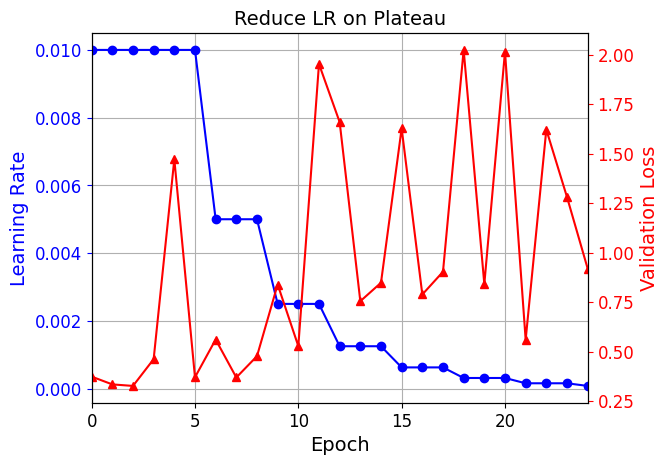

In [104]:
plt.plot(history['epoch'], history["learning_rate"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, num_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history['epoch'], history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your answer goes below

Task 6 c) answer:

Its a step wise function

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your answer goes above

## Task 7 Avoiding Overfitting Through Regularization

A **dropout layer** essentially **takes all inputs** passed to it and randomly **sets** <br>
**some inputs to 0** with a certain rate. One way that models can **overfit** to <br>
training data is by essentially *"memorizing"* or encoding into its function some <br>
**properties that are specific to one data set**.

We can help mitigate this by ensuring our data is as **non-homogeneous within** <br>
**each sample** (train, val, test) and as **homogeneous across our samples as** <br>
**possible**. This isn't always enough as we often end up showing our model the <br>
same training data multiple times and **it may learn patterns about the training** <br>
**data that don't exist in other data**.

By adding dropout, we **decrease the likelihood that it learns** these sorts of <br>
**inter-sample patterns by adding random variations** to either the data or the way <br>
it handles the same data each time.

Our models above all overfit (why?). Let's now tackle this problem using <br> dropout.

**Task 7:**   
a) Copy the code for the model of Task 6, add a dropout (20% rate) before each <br> hidden layer (https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) <br>
b) Compare the results.

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

In [115]:
model = nn.Sequential(
    nn.Flatten(),
    nn.BatchNorm1d(28*28),
    nn.Linear(28*28, 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Dropout(0.2),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Dropout(0.2),
    nn.Linear(100, 10),
)

criterion = nn.CrossEntropyLoss()
metric = accuracy_metric

optimizer = torch.optim.Adam(model.parameters())

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)
num_epochs = 25

In [116]:
history, model = train_and_validate(train_loader, valid_loader, model, optimizer, criterion, num_epochs, metric, scheduler)

Epoch [1/25], Train Loss: 0.4846, Train Metric: 0.8272, Val Loss: 0.3628, Val Metric: 0.8677
Epoch [2/25], Train Loss: 0.3806, Train Metric: 0.8605, Val Loss: 0.3359, Val Metric: 0.8797
Epoch [3/25], Train Loss: 0.3459, Train Metric: 0.8718, Val Loss: 0.3223, Val Metric: 0.8869
Epoch [4/25], Train Loss: 0.3222, Train Metric: 0.8811, Val Loss: 0.3225, Val Metric: 0.8873
Epoch [5/25], Train Loss: 0.3061, Train Metric: 0.8864, Val Loss: 0.2996, Val Metric: 0.8934
Epoch [6/25], Train Loss: 0.2932, Train Metric: 0.8907, Val Loss: 0.3055, Val Metric: 0.8932
Epoch [7/25], Train Loss: 0.2829, Train Metric: 0.8944, Val Loss: 0.3092, Val Metric: 0.8968
Epoch [8/25], Train Loss: 0.2711, Train Metric: 0.8977, Val Loss: 0.3007, Val Metric: 0.8936
Epoch [9/25], Train Loss: 0.2369, Train Metric: 0.9118, Val Loss: 0.2701, Val Metric: 0.9005
Epoch [10/25], Train Loss: 0.2262, Train Metric: 0.9150, Val Loss: 0.2971, Val Metric: 0.9007
Epoch [11/25], Train Loss: 0.2169, Train Metric: 0.9198, Val Loss: 0.

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above

In [117]:
print("train loss:", test_model(model, train_loader, nn.CrossEntropyLoss())[0])
print("test loss:", test_model(model, test_loader, nn.CrossEntropyLoss())[0])

Test Loss: 0.1285, Test Metric: 0.0000
train loss: 0.12852628492901838
Test Loss: 0.3340, Test Metric: 0.0000
test loss: 0.33395091605604077


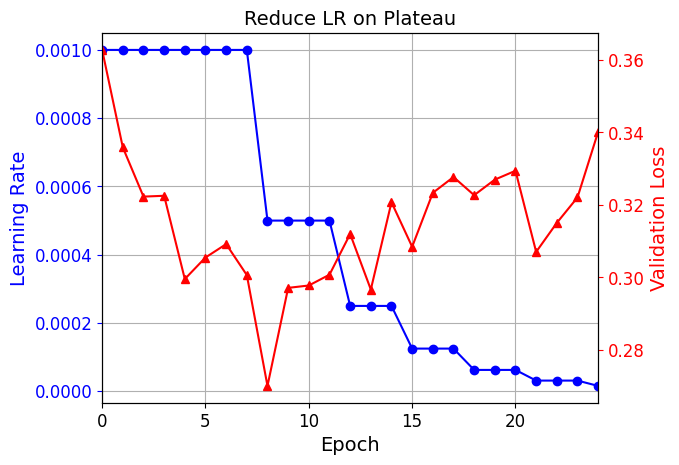

In [119]:
plt.plot(history['epoch'], history["learning_rate"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, num_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history['epoch'], history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

# Optional Exercise (Bonus points): Using Callbacks during Training

**Task 8:** Add two of the following features to your model training loop:<br>
a) Keep track of the model with the best validation loss and return the best <br>
model at the end of the traininig loop instead of the last model.<br>
b) Stop model training after 5 epochs of loss not impoving <br>
c) Add [Tensorboard logging](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) for one or more quantities from your model <br> training history

You can use the code snippets below.

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

In [120]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [124]:
def train_and_validate(train_loader, val_loader, model, optimizer, criterion, num_epochs, metric=None, scheduler=None):
    history = {
        'epoch': [],
        'train_loss': [],
        'train_metric': [],
        'val_loss': [],
        'val_metric': [],
        'learning_rate': []
    }  # Initialize a dictionary to store epoch-wise results

    with torch.no_grad():
        proper_dtype = torch.int64
        X,y = next(iter(train_loader))
        try:
            loss = criterion(model(X), y.to(proper_dtype))
        except:
            try:
                proper_dtype = torch.float32
                loss = criterion(model(X), y.to(proper_dtype))
            except:
                print("No valid data-type could be found")

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0.0  # Initialize the epoch loss and metric values
        epoch_metric = 0.0

        # Training loop
        for X, y in train_loader:
            y = y.to(proper_dtype)
            optimizer.zero_grad()  # Clear existing gradients
            outputs = model(X)  # Make predictions
            loss = criterion(outputs, y)  # Compute the loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters

            epoch_loss += loss.item()

            # THESE LINES HAVE BEEN UPDATED TO ACCOUNT FOR DEFAULT ARGUMENTS
            if metric is not None:
                epoch_metric += metric(outputs, y)
            else:
                epoch_metric += 0.0

        # Average training loss and metric
        epoch_loss /= len(train_loader)
        epoch_metric /= len(train_loader)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            val_loss = 0.0
            val_metric = 0.0
            for X_val, y_val in val_loader:
                y_val = y_val.to(proper_dtype)
                outputs_val = model(X_val)  # Make predictions
                val_loss += criterion(outputs_val, y_val).item()  # Compute loss
                if metric is not None:
                    val_metric += metric(outputs_val, y_val)
                else:
                    val_metric += 0.0

            val_loss /= len(val_loader)
            val_metric /= len(val_loader)

        # Append epoch results to history
        history['epoch'].append(epoch)
        history['train_loss'].append(epoch_loss)
        history['train_metric'].append(epoch_metric)
        history['val_loss'].append(val_loss)
        history['val_metric'].append(val_metric)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, '
              f'Train Metric: {epoch_metric:.4f}, Val Loss: {val_loss:.4f}, '
              f'Val Metric: {val_metric:.4f}')

        if scheduler is not None:
            # MODIFY THIS LINE TO WORK PROPERLY FOR REDUCELRONPLATEAU
            scheduler.step(val_loss)

    return history, model

In [125]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

def accuracy_metric(pred, target):
    if len(pred.shape) == 1:
        accuracy = torch.sum(torch.eq(pred > 0.5, target)).item() / len(pred)
    else:
        pred = pred.argmax(dim=1)
        accuracy = torch.sum(pred == target).item() / len(pred)
    return accuracy

In [126]:
history, model = train_and_validate(train_loader, valid_loader, model,
                                    optimizer=optimizer, criterion=criterion,
                                    num_epochs=50, metric=accuracy_metric)

Epoch [1/50], Train Loss: 0.4450, Train Metric: 0.8413, Val Loss: 0.5666, Val Metric: 0.8643
Epoch [2/50], Train Loss: 0.3864, Train Metric: 0.8600, Val Loss: 0.4858, Val Metric: 0.8778
Epoch [3/50], Train Loss: 0.3578, Train Metric: 0.8686, Val Loss: 0.6338, Val Metric: 0.8760
Epoch [4/50], Train Loss: 0.3440, Train Metric: 0.8743, Val Loss: 0.4048, Val Metric: 0.8833
Epoch [5/50], Train Loss: 0.3262, Train Metric: 0.8787, Val Loss: 0.2994, Val Metric: 0.8918
Epoch [6/50], Train Loss: 0.3164, Train Metric: 0.8824, Val Loss: 0.3780, Val Metric: 0.8841
Epoch [7/50], Train Loss: 0.3065, Train Metric: 0.8863, Val Loss: 0.8149, Val Metric: 0.8890
Epoch [8/50], Train Loss: 0.3058, Train Metric: 0.8874, Val Loss: 0.3224, Val Metric: 0.8904
Epoch [9/50], Train Loss: 0.2911, Train Metric: 0.8936, Val Loss: 0.3584, Val Metric: 0.8910
Epoch [10/50], Train Loss: 0.2828, Train Metric: 0.8951, Val Loss: 0.3386, Val Metric: 0.8898
Epoch [11/50], Train Loss: 0.2787, Train Metric: 0.8964, Val Loss: 0.

In [129]:
writer.flush()

In [130]:
writer.close()

In [131]:
%load_ext tensorboard
%tensorboard --logdir=./runs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above